In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import speckleret

data_path = 'C:/ML/datasets/data_f_60mm_good.mat'
# data_path = 'C:/ML/datasets/data_base_CP_CL_f_60mm_2_cameras_6_6.mat'

In [2]:
CL = loadmat(data_path)['CL']
CP = loadmat(data_path)['CP']

print(len(CL), len(CL[0]), CL[0][0].shape)
print(len(CP), len(CP[0]), CP[0][0].shape)

1 100 (512, 512)
1 100 (801, 801)


(512, 512) 34.404158160206485
(2513, 2513) 193550600.0
1.0 0.99999976


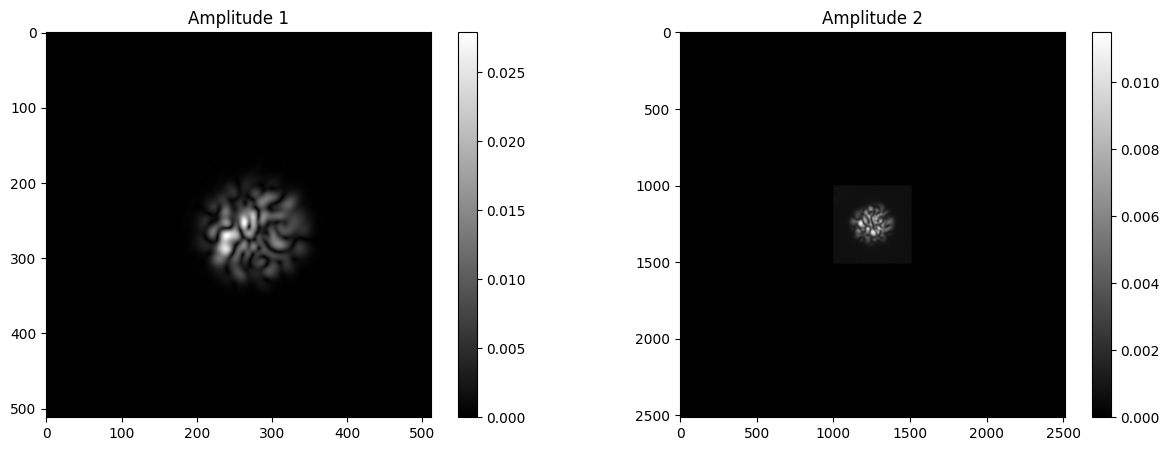

In [140]:
idx = 25
size = 256
start = 270
output_field = CP[0][idx][start:start+size, start:start+size]
output_field = speckleret.transforms.pad_img(output_field, 1)
output_field_energy = np.sum(np.square(np.abs(output_field)))
output_field = output_field / np.sqrt(output_field_energy)
print(output_field.shape, output_field_energy)

fresnel_intens = np.sqrt(CL[0][idx])
fresnel_intens = fresnel_intens[:-1,:-1]
fresnel_intens = speckleret.transforms.pad_img(fresnel_intens, 3.92)

fresnel_intens_energy = np.sum(np.square(np.abs(fresnel_intens)))
fresnel_intens = fresnel_intens / np.sqrt(fresnel_intens_energy)
print(fresnel_intens.shape, fresnel_intens_energy)

normalized_output_field_energy = np.sum(np.square(np.abs(output_field)))
normalized_fresnel_intens_energy = np.sum(np.square(np.abs(fresnel_intens)))
print(normalized_output_field_energy, normalized_fresnel_intens_energy)

_ = speckleret.plots.compare_arrays(output_field, fresnel_intens, cmap='gray')

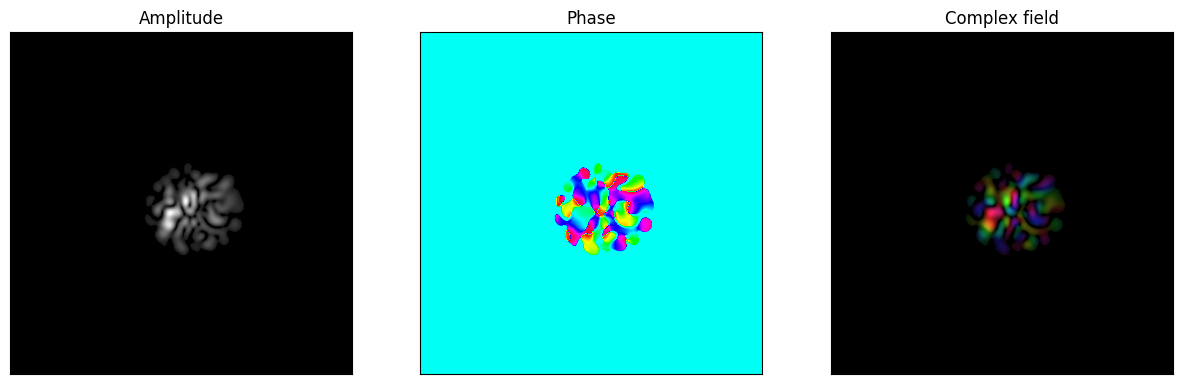

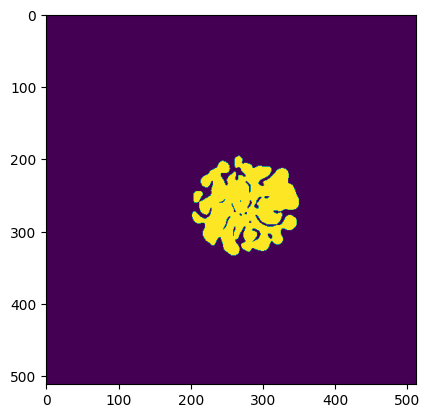

In [141]:
support = speckleret.supports.threshold_support(output_field, threshold=0.01)
supported_field = output_field.copy()
supported_field[np.logical_not(support)] = 0
_ = speckleret.plots.complex_imshow(supported_field, remove_ticks=True)
plt.show()

plt.imshow(support)

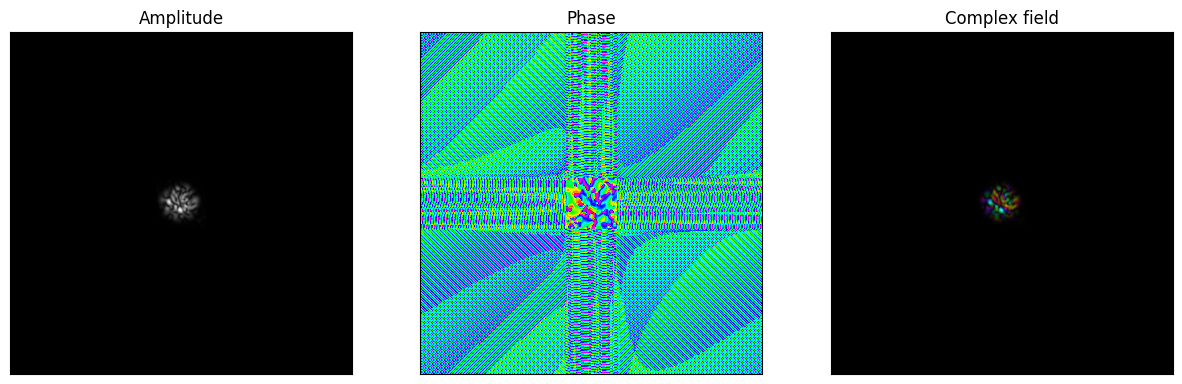

In [142]:
ft = speckleret.transforms.fourier_transform(output_field)
_ = speckleret.plots.complex_imshow(ft, remove_ticks=True)

noisy_field = speckleret.noise.add_complex_noise(output_field, intens_noise_std=0.001, phase_noise_std=0*1064e-9/100, wavelength=1064e-9)
noisy_ft = speckleret.noise.add_complex_noise(ft, intens_noise_std=0.001, phase_noise_std=0*1064e-9/100, wavelength=1064e-9)

In [168]:
max_iter = 400
beta = 0.99

field = output_field.copy()

x = np.abs(noisy_field) * np.exp(1j * 2 * np.pi * np.random.rand(*field.shape))

mse = []
quality = []
quality_phi = []
for i in range(max_iter):
    metric = speckleret.metrics.mse(speckleret.transforms.fourier_transform(x), np.abs(noisy_ft))
    q = speckleret.metrics.quality(x[support], noisy_field[support], inversed=True)
    q_phi = speckleret.metrics.quality(np.exp(1j * np.angle(x[support])), np.exp(1j * np.angle(noisy_field[support])), inversed=True)
    mse.append(metric)
    quality.append(q)
    quality_phi.append(q_phi)

    # x = speckleret.retrievalmath.ER(x=x, magnitude_S=np.abs(noisy_field), magnitude_M=np.abs(noisy_ft), support=support)
    # x = speckleret.retrievalmath.SF(x=x, magnitude_S=np.abs(noisy_field), magnitude_M=np.abs(noisy_ft), support=support)
    # x = speckleret.retrievalmath.HIO(x=x, magnitude_S=np.abs(noisy_field), magnitude_M=np.abs(noisy_ft), support=support, beta=beta)
    x = speckleret.retrievalmath.DM(x=x, magnitude_S=np.abs(noisy_field), magnitude_M=np.abs(noisy_ft), support=support, beta=beta)
    # x = speckleret.retrievalmath.ASR(x=x, magnitude_S=np.abs(noisy_field), magnitude_M=np.abs(noisy_ft), support=support)
    # x = speckleret.retrievalmath.HPR(x=x, magnitude_S=np.abs(noisy_field), magnitude_M=np.abs(noisy_ft), support=support, beta=beta)
    # x = speckleret.retrievalmath.RAAR(x=x, magnitude_S=np.abs(noisy_field), magnitude_M=np.abs(noisy_ft), support=support, beta=beta)

    if i == 0:
        q_best, x_best = q, x
    else:
        if q < q_best:
            q_best, x_best = q, x

Qualities:	 Last = 0.98525,	 Last_phi = 0.95127,	 Best = 0.98614,	 Best_phi = 0.95709
Pearsons: 	 Last = 0.96120,	 Best = 0.96215


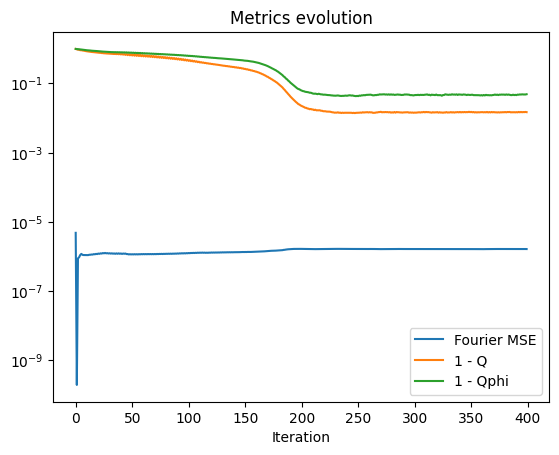

In [169]:
q_best_phi = speckleret.metrics.quality(np.exp(1j * np.angle(x_best[support])), np.exp(1j * np.angle(noisy_field[support])))
pearson = speckleret.metrics.pearson(x[support], noisy_field[support])
pearson_best = speckleret.metrics.pearson(x_best[support], noisy_field[support])

print(f"Qualities:\t Last = {1-q:3.5f},\t Last_phi = {1-q_phi:3.5f},\t Best = {1-q_best:3.5f},\t Best_phi = {q_best_phi:3.5f}")
print(f"Pearsons: \t Last = {pearson:3.5f},\t Best = {pearson_best:3.5f}")

plt.figure()
plt.plot(mse, label='Fourier MSE')
plt.plot(quality, label='1 - Q')
plt.plot(quality_phi, label='1 - Qphi')
plt.yscale('log')
plt.title('Metrics evolution')
plt.xlabel('Iteration')
plt.legend()

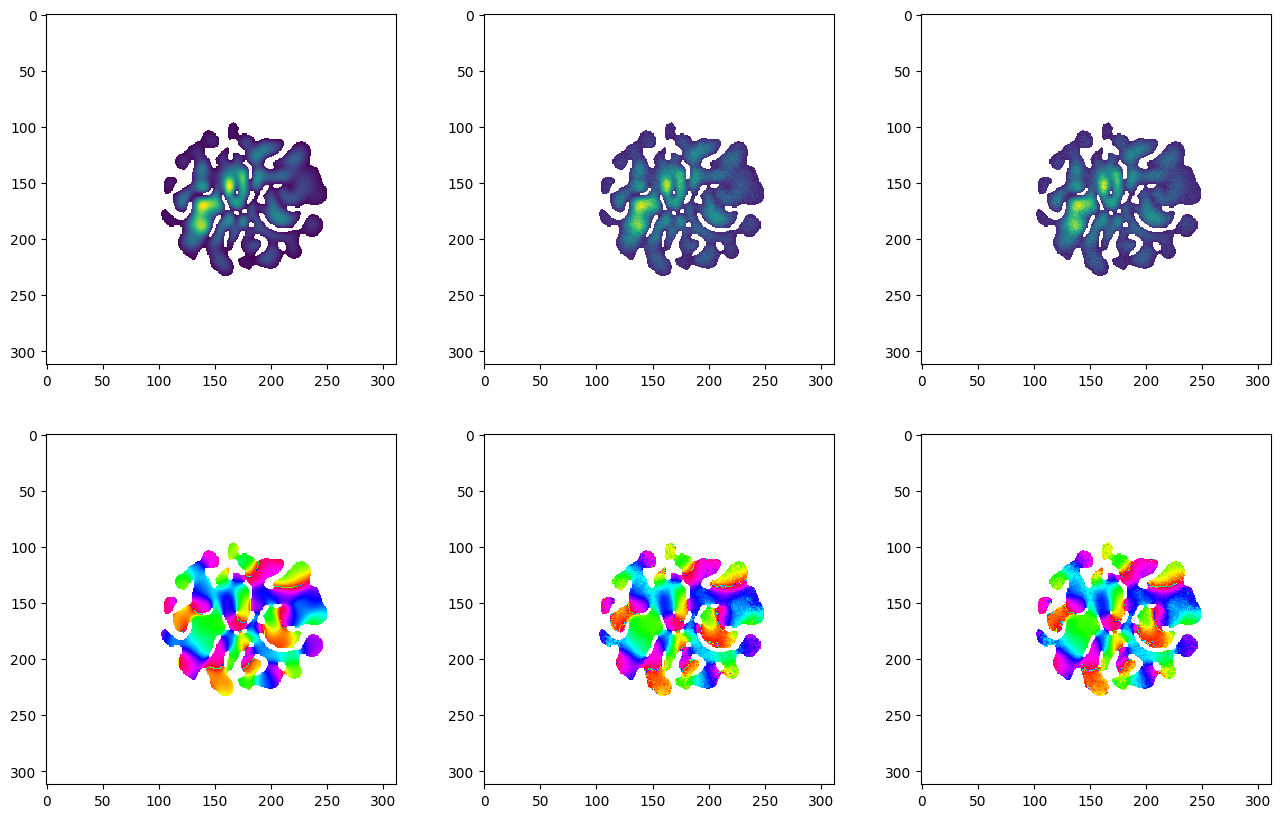

In [170]:
dcrop = 100

disp_field = field.copy()
disp_field[np.logical_not(support)] = np.nan
disp_field = disp_field[dcrop:-dcrop, dcrop:-dcrop]

disp_x = x.copy()
disp_x[np.logical_not(support)] = np.nan
disp_x = disp_x[dcrop:-dcrop, dcrop:-dcrop]

disp_best = x_best.copy()
disp_best[np.logical_not(support)] = np.nan
disp_best = disp_best[dcrop:-dcrop, dcrop:-dcrop]

ref = [150,150]

fig, axs = plt.subplots(2, 3, figsize=(16,10))
axs[0,0].imshow(np.abs(disp_field))
axs[0,1].imshow(np.abs(disp_x))
axs[0,2].imshow(np.abs(disp_best))
axs[1,0].imshow(np.angle(disp_field * np.exp(-1j * np.angle(disp_field[ref[0],ref[1]]))), cmap='hsv')
axs[1,1].imshow(np.angle(disp_x * np.exp(-1j * np.angle(disp_x[ref[0],ref[1]]))), cmap='hsv')
axs[1,2].imshow(np.angle(disp_best * np.exp(-1j * np.angle(disp_best[ref[0],ref[1]]))), cmap='hsv')

# _ = [axs[i,j].set_xticks([]) for i in range(len(axs)) for j in range(len(axs[0]))]
# _ = [axs[i,j].set_yticks([]) for i in range(len(axs)) for j in range(len(axs[0]))]